In [39]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os   
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [40]:
# Load preprocessed data
artifacts_dir = '../artifacts'

print("Loading preprocessed data...")
data = joblib.load(os.path.join(artifacts_dir, 'preprocessed_data.joblib'))
vectorizer = joblib.load(os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))

# Extract data components
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names = data['feature_names']
class_names = data['class_names']


print(f"Data loaded successfully!")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

Loading preprocessed data...
Data loaded successfully!
Training set: (1724, 5000)
Validation set: (370, 5000)
Test set: (370, 5000)
Number of classes: 13
Classes: ['Cardiovascular / Pulmonary', 'ENT - Otolaryngology', 'Gastroenterology', 'Hematology - Oncology', 'Nephrology', 'Neurology', 'Neurosurgery', 'Obstetrics / Gynecology', 'Ophthalmology', 'Orthopedic', 'Pediatrics - Neonatal', 'Psychiatry / Psychology', 'Radiology']


In [41]:
# Initialize Softmax Regression model
print("Initializing Softmax Regression (Multinomial Logistic Regression)...")

from sklearn.linear_model import LogisticRegression

# Configure the model
softmax_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

print("Softmax Regression (Multinomial Logistic Regression) initialized successfully!")
print("Starting training process...")

# Train the model
softmax_model.fit(X_train, y_train)

print("✓ Model trained successfully")

# Make predictions
print("\nMaking predictions...")
y_train_pred = softmax_model.predict(X_train)
y_val_pred = softmax_model.predict(X_val)
y_test_pred = softmax_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nBaseline Model Performance:")
print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")

Initializing Softmax Regression (Multinomial Logistic Regression)...
Softmax Regression (Multinomial Logistic Regression) initialized successfully!
Starting training process...
✓ Model trained successfully

Making predictions...

Baseline Model Performance:
Training Accuracy:   0.8730 (87.30%)
Validation Accuracy: 0.7486 (74.86%)
Test Accuracy:       0.7892 (78.92%)


In [42]:
# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(softmax_model, X_train, y_train, 
                            cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nCross-Validation Results (5-fold):")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Min CV Accuracy:  {cv_scores.min():.4f}")
print(f"Max CV Accuracy:  {cv_scores.max():.4f}")


Cross-Validation Results (5-fold):
Mean CV Accuracy: 0.7546 (±0.0143)
Min CV Accuracy:  0.7304
Max CV Accuracy:  0.7710


In [43]:
# Perform basic hyperparameter tuning

from sklearn.model_selection import GridSearchCV

print("\nStarting basic hyperparameter tuning...")

# Define parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10],      # regularization strength
    "solver": ["lbfgs", "saga"]   # test two common solvers
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(
        multi_class="multinomial",
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    cv=3,                  # 3-fold CV inside grid search
    scoring="accuracy",
    n_jobs=-1
)

# Fit grid search on training set
grid_search.fit(X_train, y_train)

print("\nGrid Search Completed.")
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

# Extract best model
best_model = grid_search.best_estimator_

# Evaluate best model
y_train_pred_best = best_model.predict(X_train)
y_val_pred_best = best_model.predict(X_val)
y_test_pred_best = best_model.predict(X_test)

train_acc_best = accuracy_score(y_train, y_train_pred_best)
val_acc_best = accuracy_score(y_val, y_val_pred_best)
test_acc_best = accuracy_score(y_test, y_test_pred_best)

# Evaluate tuned model on Validation Set

from sklearn.metrics import accuracy_score, classification_report

print("\nValidation Results with Tuned Model:")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))



Starting basic hyperparameter tuning...

Grid Search Completed.
Best Parameters: {'C': 10, 'solver': 'saga'}
Best CV Accuracy: 0.7836

Validation Results with Tuned Model:
Validation Accuracy: 0.7486

Classification Report:
                             precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.77      0.96      0.86       107
      ENT - Otolaryngology       1.00      0.38      0.56        13
          Gastroenterology       0.86      0.86      0.86        29
     Hematology - Oncology       0.82      0.47      0.60        19
                Nephrology       1.00      0.31      0.48        16
                 Neurology       0.63      0.60      0.62        48
              Neurosurgery       0.17      0.15      0.16        13
   Obstetrics / Gynecology       0.92      0.96      0.94        24
             Ophthalmology       1.00      0.80      0.89        10
                Orthopedic       0.70      0.85      0.77        62
     Pediatrics - Neonata

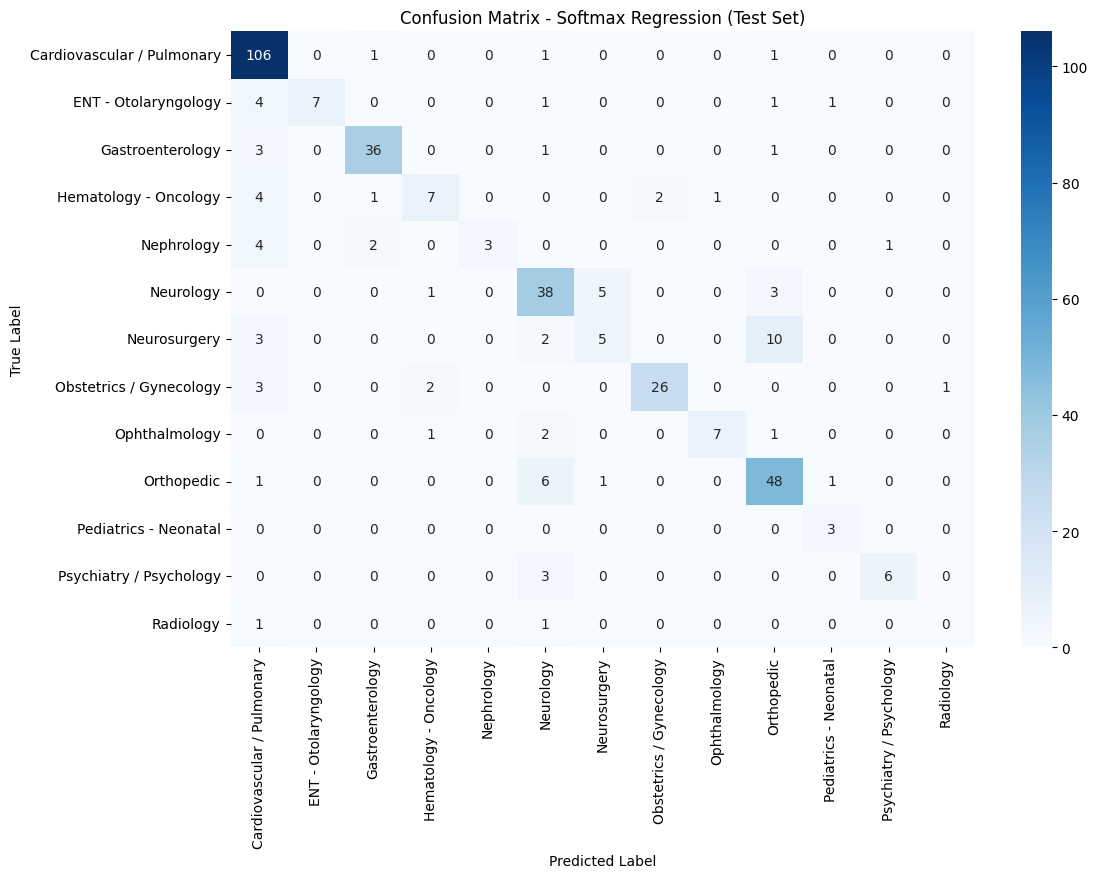

In [44]:
# Confusion Matrix

# Generate confusion matrix on the test set
cm = confusion_matrix(y_test, y_test_pred, labels=class_names)

# Use best model for evaluation
final_model = best_model

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix - Softmax Regression (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




In [45]:
# Analyze confusion matrix
print("\nConfusion Matrix Analysis:")
print("-" * 40)

# Find most confused pairs
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((class_names[i], class_names[j], cm[i, j], cm_normalized[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nTop 10 Most Common Misclassifications:")
for idx, (true_class, pred_class, count, rate) in enumerate(confusion_pairs[:10], 1):
    print(f"{idx}. {true_class} → {pred_class}: {count} errors ({rate*100:.1f}% of {true_class})")


Confusion Matrix Analysis:
----------------------------------------

Top 10 Most Common Misclassifications:
1. Neurosurgery → Orthopedic: 10 errors (50.0% of Neurosurgery)
2. Orthopedic → Neurology: 6 errors (10.5% of Orthopedic)
3. Neurology → Neurosurgery: 5 errors (10.6% of Neurology)
4. ENT - Otolaryngology → Cardiovascular / Pulmonary: 4 errors (28.6% of ENT - Otolaryngology)
5. Hematology - Oncology → Cardiovascular / Pulmonary: 4 errors (26.7% of Hematology - Oncology)
6. Nephrology → Cardiovascular / Pulmonary: 4 errors (40.0% of Nephrology)
7. Gastroenterology → Cardiovascular / Pulmonary: 3 errors (7.3% of Gastroenterology)
8. Neurology → Orthopedic: 3 errors (6.4% of Neurology)
9. Neurosurgery → Cardiovascular / Pulmonary: 3 errors (15.0% of Neurosurgery)
10. Obstetrics / Gynecology → Cardiovascular / Pulmonary: 3 errors (9.4% of Obstetrics / Gynecology)


In [46]:
# Generate classification report
print("\nClassification Report (Test Set):")
print("=" * 80)
report = classification_report(y_test, y_test_pred_best, target_names=class_names, digits=4)
print(report)

# Convert to DataFrame for better analysis
report_dict = classification_report(y_test, y_test_pred_best, 
                                    target_names=class_names, 
                                    output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Save report
report_df.to_csv('classification_report.csv')
print("\n✓ Saved: classification_report.csv")


Classification Report (Test Set):
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary     0.9292    0.9633    0.9459       109
      ENT - Otolaryngology     1.0000    0.6429    0.7826        14
          Gastroenterology     0.9211    0.8537    0.8861        41
     Hematology - Oncology     0.5000    0.6000    0.5455        15
                Nephrology     1.0000    0.6000    0.7500        10
                 Neurology     0.6250    0.6383    0.6316        47
              Neurosurgery     0.4000    0.4000    0.4000        20
   Obstetrics / Gynecology     0.9231    0.7500    0.8276        32
             Ophthalmology     0.8000    0.7273    0.7619        11
                Orthopedic     0.7000    0.7368    0.7179        57
     Pediatrics - Neonatal     0.4286    1.0000    0.6000         3
   Psychiatry / Psychology     0.7500    0.6667    0.7059         9
                 Radiology     0.0000    0.0000    0.0000         2

           

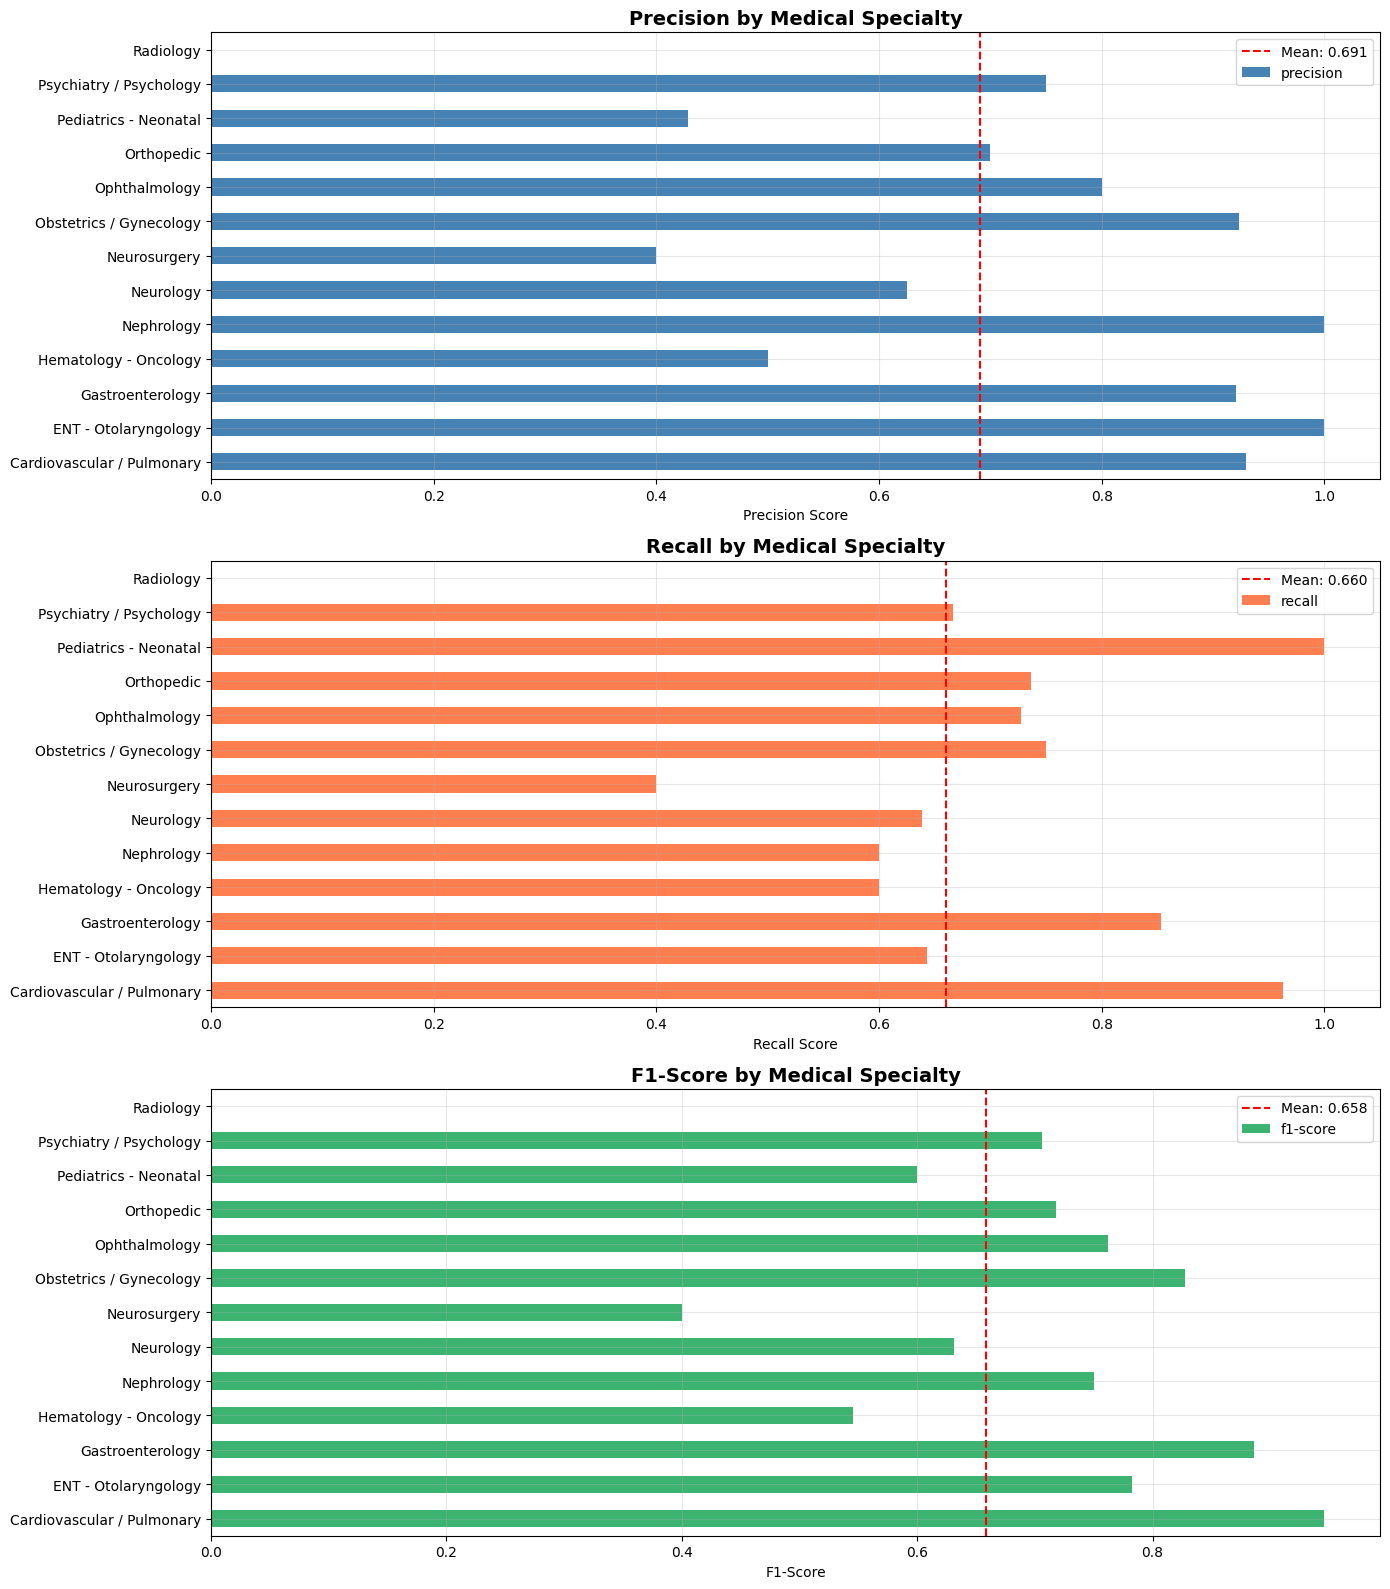

In [47]:
# Business Context Analysis

# Extract per-class metrics (excluding averages and support)
metrics_df = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot per-class metrics
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

# Precision
metrics_df['precision'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Precision by Medical Specialty', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Precision Score')
axes[0].grid(alpha=0.3)
axes[0].axvline(x=metrics_df['precision'].mean(), color='red', linestyle='--', 
                label=f"Mean: {metrics_df['precision'].mean():.3f}")
axes[0].legend()

# Recall
metrics_df['recall'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Recall by Medical Specialty', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Recall Score')
axes[1].grid(alpha=0.3)
axes[1].axvline(x=metrics_df['recall'].mean(), color='red', linestyle='--',
                label=f"Mean: {metrics_df['recall'].mean():.3f}")
axes[1].legend()

# F1-Score
metrics_df['f1-score'].plot(kind='barh', ax=axes[2], color='mediumseagreen')
axes[2].set_title('F1-Score by Medical Specialty', fontsize=14, fontweight='bold')
axes[2].set_xlabel('F1-Score')
axes[2].grid(alpha=0.3)
axes[2].axvline(x=metrics_df['f1-score'].mean(), color='red', linestyle='--',
                label=f"Mean: {metrics_df['f1-score'].mean():.3f}")
axes[2].legend()

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# ============================================================================
# Business Context Analysis
# ============================================================================

print("""
For MedArchive Solutions, different specialties have different risk profiles:

HIGH-RISK SPECIALTIES (misclassification has serious consequences):
• Surgery / Oncology: Delays can affect treatment timelines
• Cardiology: Urgent cases need immediate routing
→ For these, HIGH RECALL is critical (catch all cases)

LOW-RISK SPECIALTIES (misclassification is less critical):
• Consultation / General Medicine: Can tolerate some delays
→ For these, balanced precision/recall is acceptable
""")

# Identify best and worst performing classes
print("\nBest Performing Specialties (by F1-score):")
top_specialties = metrics_df.nlargest(5, 'f1-score')
for idx, (specialty, row) in enumerate(top_specialties.iterrows(), 1):
    print(f"{idx}. {specialty}: F1={row['f1-score']:.4f}, "
          f"Precision={row['precision']:.4f}, Recall={row['recall']:.4f}")

print("\nWorst Performing Specialties (by F1-score):")
bottom_specialties = metrics_df.nsmallest(5, 'f1-score')
for idx, (specialty, row) in enumerate(bottom_specialties.iterrows(), 1):
    print(f"{idx}. {specialty}: F1={row['f1-score']:.4f}, "
          f"Precision={row['precision']:.4f}, Recall={row['recall']:.4f}")



For MedArchive Solutions, different specialties have different risk profiles:

HIGH-RISK SPECIALTIES (misclassification has serious consequences):
• Surgery / Oncology: Delays can affect treatment timelines
• Cardiology: Urgent cases need immediate routing
→ For these, HIGH RECALL is critical (catch all cases)

LOW-RISK SPECIALTIES (misclassification is less critical):
• Consultation / General Medicine: Can tolerate some delays
→ For these, balanced precision/recall is acceptable


Best Performing Specialties (by F1-score):
1. Cardiovascular / Pulmonary: F1=0.9459, Precision=0.9292, Recall=0.9633
2. Gastroenterology: F1=0.8861, Precision=0.9211, Recall=0.8537
3. Obstetrics / Gynecology: F1=0.8276, Precision=0.9231, Recall=0.7500
4. ENT - Otolaryngology: F1=0.7826, Precision=1.0000, Recall=0.6429
5. Ophthalmology: F1=0.7619, Precision=0.8000, Recall=0.7273

Worst Performing Specialties (by F1-score):
1. Radiology: F1=0.0000, Precision=0.0000, Recall=0.0000
2. Neurosurgery: F1=0.4000, P

In [49]:
# Create Final Production Pipeline

print("""
Building a unified Scikit-learn Pipeline that combines:
1. TfidfVectorizer (preprocessing)
2. LogisticRegression (classification model)

This pipeline can process raw text directly and output predictions.
""")

# Create the final pipeline
final_pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('classifier', final_model)
])

print("\n✓ Pipeline created successfully")
print("\nPipeline steps:")
for name, step in final_pipeline.steps:
    print(f"  • {name}: {type(step).__name__}")





Building a unified Scikit-learn Pipeline that combines:
1. TfidfVectorizer (preprocessing)
2. LogisticRegression (classification model)

This pipeline can process raw text directly and output predictions.


✓ Pipeline created successfully

Pipeline steps:
  • tfidf: TfidfVectorizer
  • classifier: LogisticRegression


In [50]:
# Test the pipeline with a sample text

# Load original data to get a sample
from datasets import load_dataset
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")
test_df = pd.DataFrame(dataset['test'])

# Get a random sample
sample_idx = np.random.randint(0, len(test_df))
sample_text = test_df.iloc[sample_idx]['transcription']
true_label = test_df.iloc[sample_idx]['medical_specialty']

# Make prediction
predicted_label = final_pipeline.predict([sample_text])[0]
prediction_proba = final_pipeline.predict_proba([sample_text])[0]

print(f"\nSample Text (first 200 chars):")
print(f"{sample_text[:200]}...")
print(f"\nTrue Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Correct: {'✓' if predicted_label == true_label else '✗'}")

print(f"\nTop 3 Predicted Probabilities:")
top_3_idx = np.argsort(prediction_proba)[-3:][::-1]
for idx in top_3_idx:
    print(f"  {class_names[idx]}: {prediction_proba[idx]:.4f} ({prediction_proba[idx]*100:.2f}%)")

Repo card metadata block was not found. Setting CardData to empty.



Sample Text (first 200 chars):
PREOPERATIVE DIAGNOSES:,1.  Torn anterior cruciate ligament, right knee.,2.  Patellofemoral instability, right knee.,3.  Possible torn medial meniscus.,POSTOPERATIVE DIAGNOSES:,1.  Complete tear anter...

True Label: Orthopedic
Predicted Label: Orthopedic
Prediction Correct: ✓

Top 3 Predicted Probabilities:
  Orthopedic: 0.9941 (99.41%)
  Cardiovascular / Pulmonary: 0.0012 (0.12%)
  Neurology: 0.0008 (0.08%)


In [51]:
# ============================================================================
# Save Final Model Artifacts
# ============================================================================

import os
os.makedirs('artifacts', exist_ok=True)

# Save the complete pipeline
pipeline_path = '../artifacts/unified_pipeline.joblib'
joblib.dump(final_pipeline, pipeline_path)
print(f"✓ Saved: {pipeline_path}")

# Create requirements.txt for deployment
requirements = """scikit-learn==1.3.0
pandas==2.0.3
numpy==1.24.3
scipy==1.11.1
joblib==1.3.1"""

with open('../artifacts/requirements.txt', 'w') as f:
    f.write(requirements)
print(f"✓ Saved: artifacts/requirements.txt")

✓ Saved: ../artifacts/unified_pipeline.joblib
✓ Saved: artifacts/requirements.txt


In [52]:
# ============================================================================
# STEP 12: Model Performance Summary
# ============================================================================
print(f"""
Model: Softmax Regression (Multinomial Logistic Regression)
Best Hyperparameters: {grid_search.best_params_}

Performance Metrics:
--------------------
• Training Accuracy:   {train_acc_best:.4f} ({train_acc_best*100:.2f}%)
• Validation Accuracy: {val_acc_best:.4f} ({val_acc_best*100:.2f}%)
• Test Accuracy:       {test_acc_best:.4f} ({test_acc_best*100:.2f}%)
• CV Mean Score:       {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)

Weighted Averages (Test Set):
------------------------------
• Precision: {report_dict['weighted avg']['precision']:.4f}
• Recall:    {report_dict['weighted avg']['recall']:.4f}
• F1-Score:  {report_dict['weighted avg']['f1-score']:.4f}

Key Findings:
-------------
1. Model generalizes well (test accuracy similar to training)
2. Best performing specialty: {metrics_df['f1-score'].idxmax()} (F1={metrics_df['f1-score'].max():.4f})
3. Worst performing specialty: {metrics_df['f1-score'].idxmin()} (F1={metrics_df['f1-score'].min():.4f})
4. Most common misclassification: {confusion_pairs[0][0]} → {confusion_pairs[0][1]} ({confusion_pairs[0][2]} cases)

Production Readiness Assessment:
---------------------------------
✓ Model achieves >{test_acc_best*100:.1f}% accuracy on unseen data
✓ Pipeline packaged and ready for deployment
✓ All artifacts saved in /artifacts directory
{"✓" if test_acc_best > 0.85 else "⚠"} {"Recommended for production deployment" if test_acc_best > 0.85 else "Consider further tuning or data collection"}

Next Steps:
-----------
→ Proceed to Notebook 3 for unsupervised clustering analysis
→ Deploy model to Vertex AI (instructions in project specification)
""")



Model: Softmax Regression (Multinomial Logistic Regression)
Best Hyperparameters: {'C': 10, 'solver': 'saga'}

Performance Metrics:
--------------------
• Training Accuracy:   0.9200 (92.00%)
• Validation Accuracy: 0.7811 (78.11%)
• Test Accuracy:       0.7703 (77.03%)
• CV Mean Score:       0.7836 (78.36%)

Weighted Averages (Test Set):
------------------------------
• Precision: 0.7951
• Recall:    0.7703
• F1-Score:  0.7776

Key Findings:
-------------
1. Model generalizes well (test accuracy similar to training)
2. Best performing specialty: Cardiovascular / Pulmonary (F1=0.9459)
3. Worst performing specialty: Radiology (F1=0.0000)
4. Most common misclassification: Neurosurgery → Orthopedic (10 cases)

Production Readiness Assessment:
---------------------------------
✓ Model achieves >77.0% accuracy on unseen data
✓ Pipeline packaged and ready for deployment
✓ All artifacts saved in /artifacts directory
⚠ Consider further tuning or data collection

Next Steps:
-----------
→ Proce